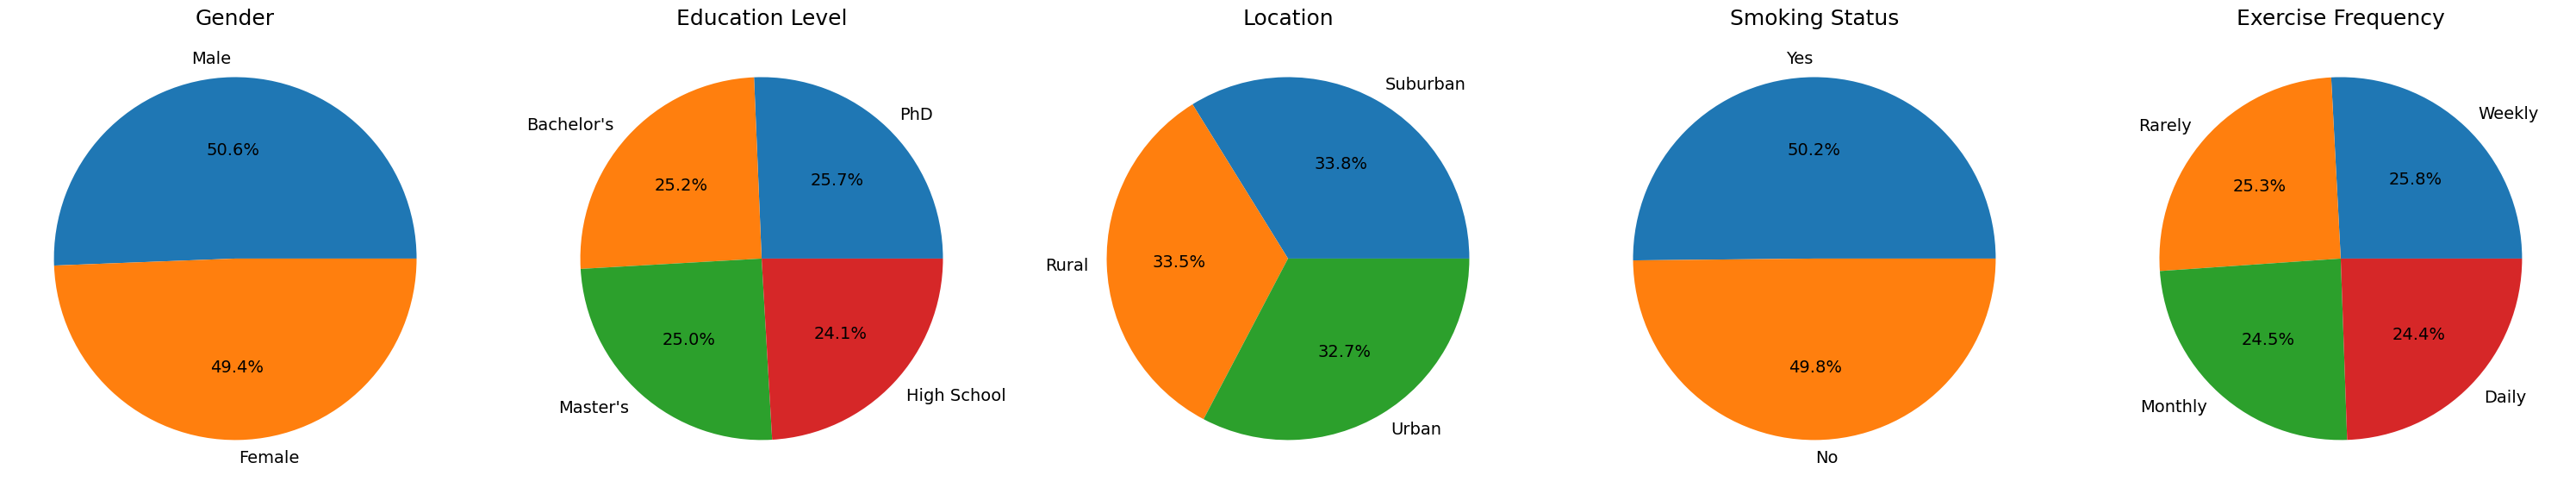

Axes(0.125,0.11;0.227941x0.226471)
The Mean Absolute Error for Linear Regression is 656.2275604700772
The Mean Absolute Error for Lasso is 656.2087433786979
(6711, 7)
Dimensions of preprocessed training dataset: (6711, 12)
Training data dimensions (X_train): (15717, 7)
Validation data dimensions (X_val): (3930, 7)
Training target dimensions (y_train): (15717, 1)
Validation target dimensions (y_val): (3930, 1)


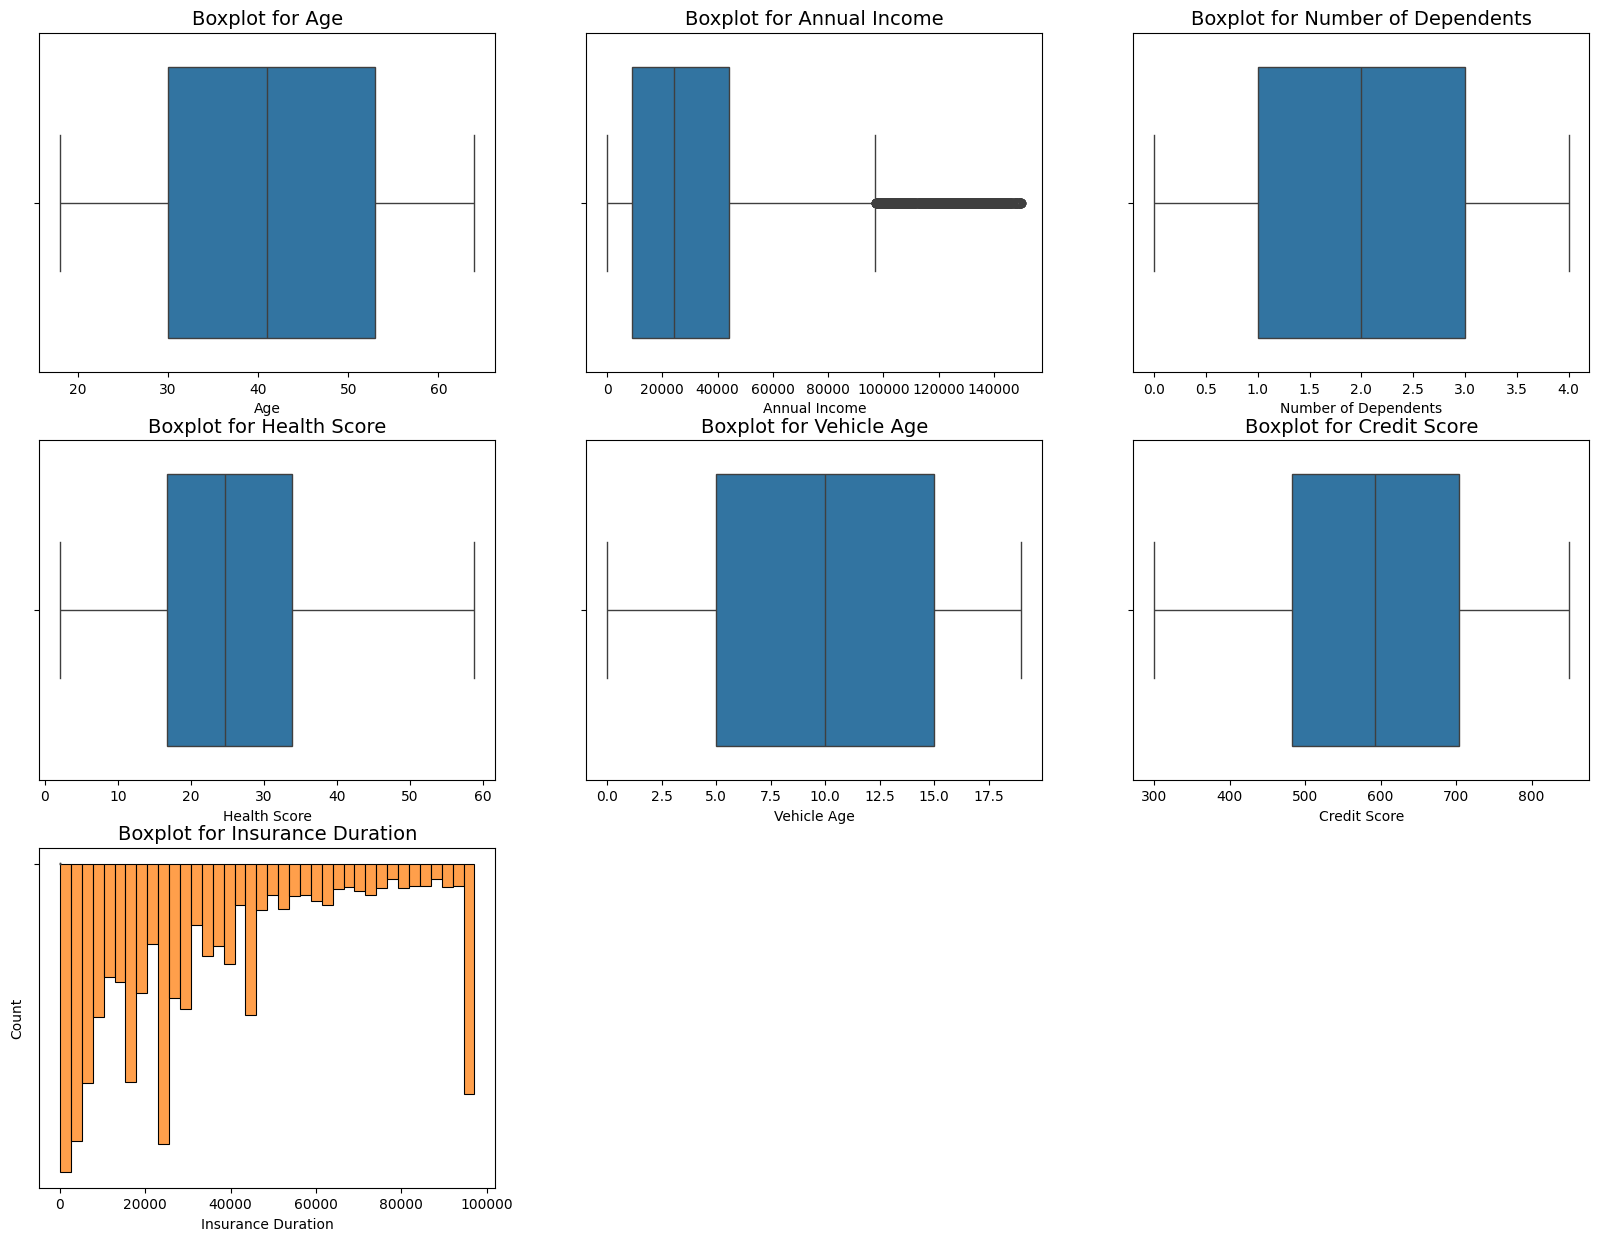

In [2]:
#regression with an insurance dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/train.csv')
columns_name = df.columns
features_X = df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type","Premium Amount"])
pred = df[["Premium Amount"]]
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)
# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())
# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])
# Drop the rows where that column has very few missing value
features_X = features_X.dropna(subset=["Vehicle Age","Insurance Duration"])
# Split features_X to categorial_columns and numerial_columns
categorial_columns = features_X.select_dtypes(include=["object","category"])
numerical_columns = features_X.select_dtypes(include=["number"])

# Visualize categorial columns data
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 20))  # Set the overall figure size
for i, col in enumerate(categorial_columns):
    plt.subplot(1, len(categorial_columns.columns), i + 1)  # Dynamically handle subplot positions

    x = categorial_columns[col].value_counts()
    plt.pie(
        x.values,
        labels=x.index,
        autopct="%1.1f%%",
        textprops={'fontsize': 14}  # Adjust font size for readability
    )
    plt.title(col, fontsize=18)  # Add a title for each subplot

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()
# Visualize numerical data
num_cols = len(numerical_columns.columns)
rows = (num_cols + 2) // 3
plt.figure(figsize=(20, rows * 5))
# Plot boxplots for initial data
for i, col in enumerate(numerical_columns.columns, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(x=numerical_columns[col])
    plt.xlabel(col)
    plt.title(f'Boxplot for {col}', fontsize=14)

# Replace Outliers with mean value
while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns["Annual Income"]=np.clip(numerical_columns["Annual Income"], LowerBound, UpperBound)

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

print(sns.histplot(numerical_columns["Annual Income"]))

from scipy import stats

# Apply Box-Cox transformation first
numerical_columns["Annual Income"] = np.log1p(numerical_columns["Annual Income"])

from sklearn.model_selection import train_test_split
# Make both columns consistent with the index across both columns
numerical_columns = numerical_columns.reset_index(drop=True)
X = numerical_columns

# Divide data into training and validation data
pred = pred.loc[X.index]
X = X.reset_index(drop=True)
pred = pred.reset_index(drop=True)
X_train,X_val,y_train,y_val = train_test_split(X,pred,test_size=0.2)

X_train

# Model Development
from sklearn.linear_model import LinearRegression, Lasso

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)
y_pred = lrmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'The Mean Absolute Error for Linear Regression is {mae}')

lasmodel = Lasso()
lasmodel.fit(X_train,y_train)
y_pred = lasmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"The Mean Absolute Error for Lasso is {mae}")

test_df = pd.read_csv("/content/test.csv")
features_X = test_df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type"])
# Remove columns that have excessive NaN values
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)

# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())

# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])

# Drop the rows where that column has very few missing value
features_X["Vehicle Age"] = features_X["Vehicle Age"].fillna(features_X["Vehicle Age"].median())
features_X["Insurance Duration"] = features_X["Insurance Duration"].fillna(features_X["Insurance Duration"].median())

# Split features_X to categorial_columns and numerial_columns
numerical_columns = features_X.select_dtypes(include=["number"])

while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns.loc[numerical_columns["Annual Income"] >= UpperBound, "Annual Income"] = UpperBound
    numerical_columns.loc[numerical_columns["Annual Income"] <= LowerBound, "Annual Income"] = LowerBound

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

# Apply Box-Cox transformation first
numerical_columns["Annual Income"], fitted_lambda = stats.boxcox(numerical_columns["Annual Income"] + 1)

numerical_columns = numerical_columns.reset_index(drop=True)

X = numerical_columns

test_pred = lrmodel.predict(X).flatten()
submission = pd.DataFrame({
    "id": test_df["id"],
    "Premium Amount": test_pred
})
submission.to_csv("submission.csv",index=False)

print(X.shape)
print("Dimensions of preprocessed training dataset:", features_X.shape)
print("Training data dimensions (X_train):", X_train.shape)
print("Validation data dimensions (X_val):", X_val.shape)
print("Training target dimensions (y_train):", y_train.shape)
print("Validation target dimensions (y_val):", y_val.shape)



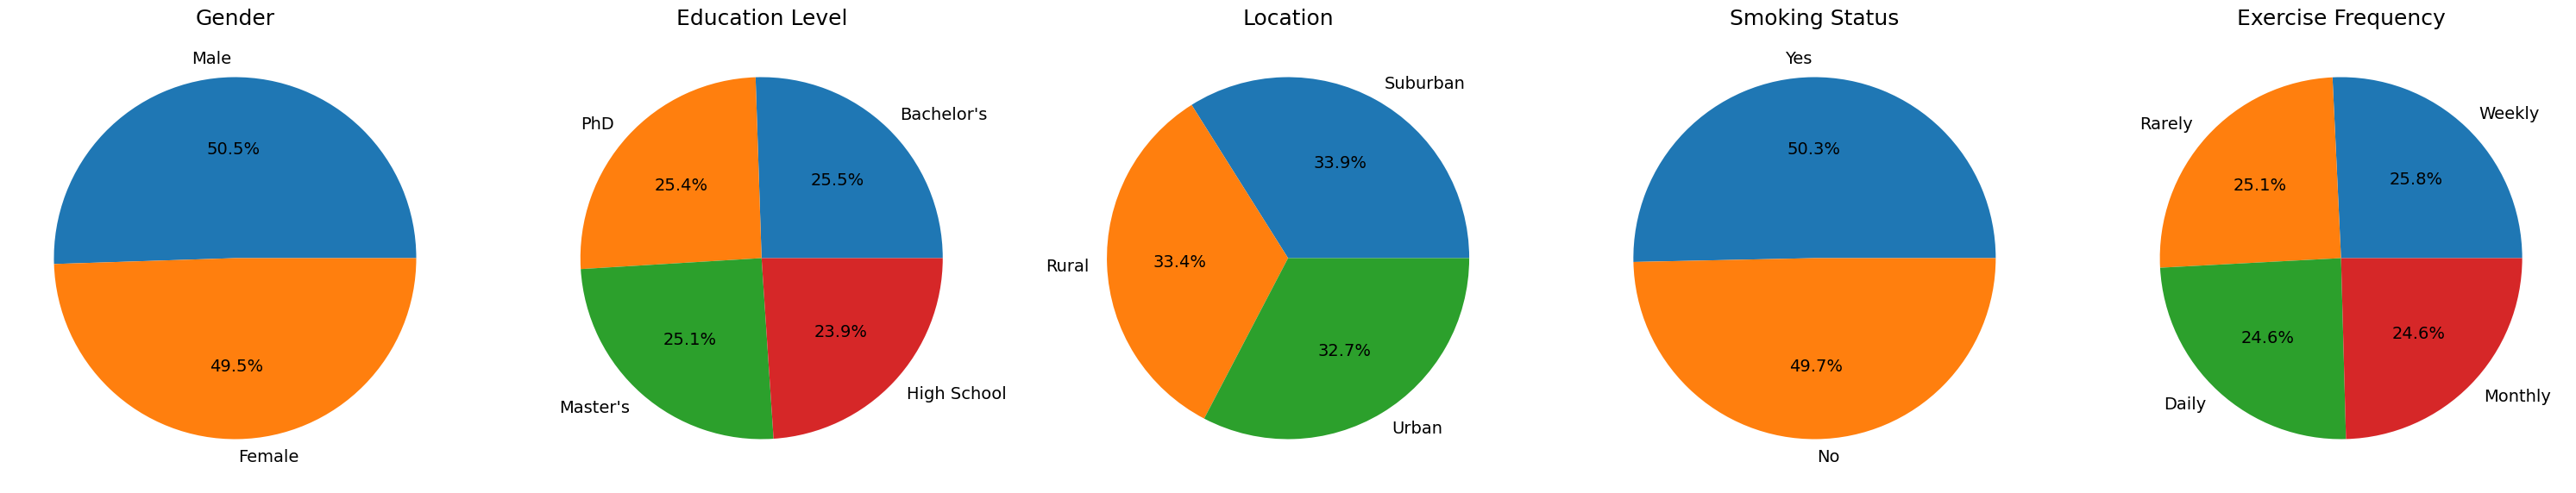

Axes(0.125,0.11;0.227941x0.226471)
The Mean Absolute Error for Linear Regression is 673.1607238559268
The Mean Absolute Error for Lasso is 673.1487479567472
(26842, 7)
Dimensions of preprocessed training dataset: (26842, 12)
Training data dimensions (X_train): (31378, 7)
Validation data dimensions (X_val): (7845, 7)
Training target dimensions (y_train): (31378, 1)
Validation target dimensions (y_val): (7845, 1)
The Mean Absolute Error for Decision Tree is 689.2464873624291
The Root Mean Squared Error (RMSE) for Decision Tree is 818925.4195655226


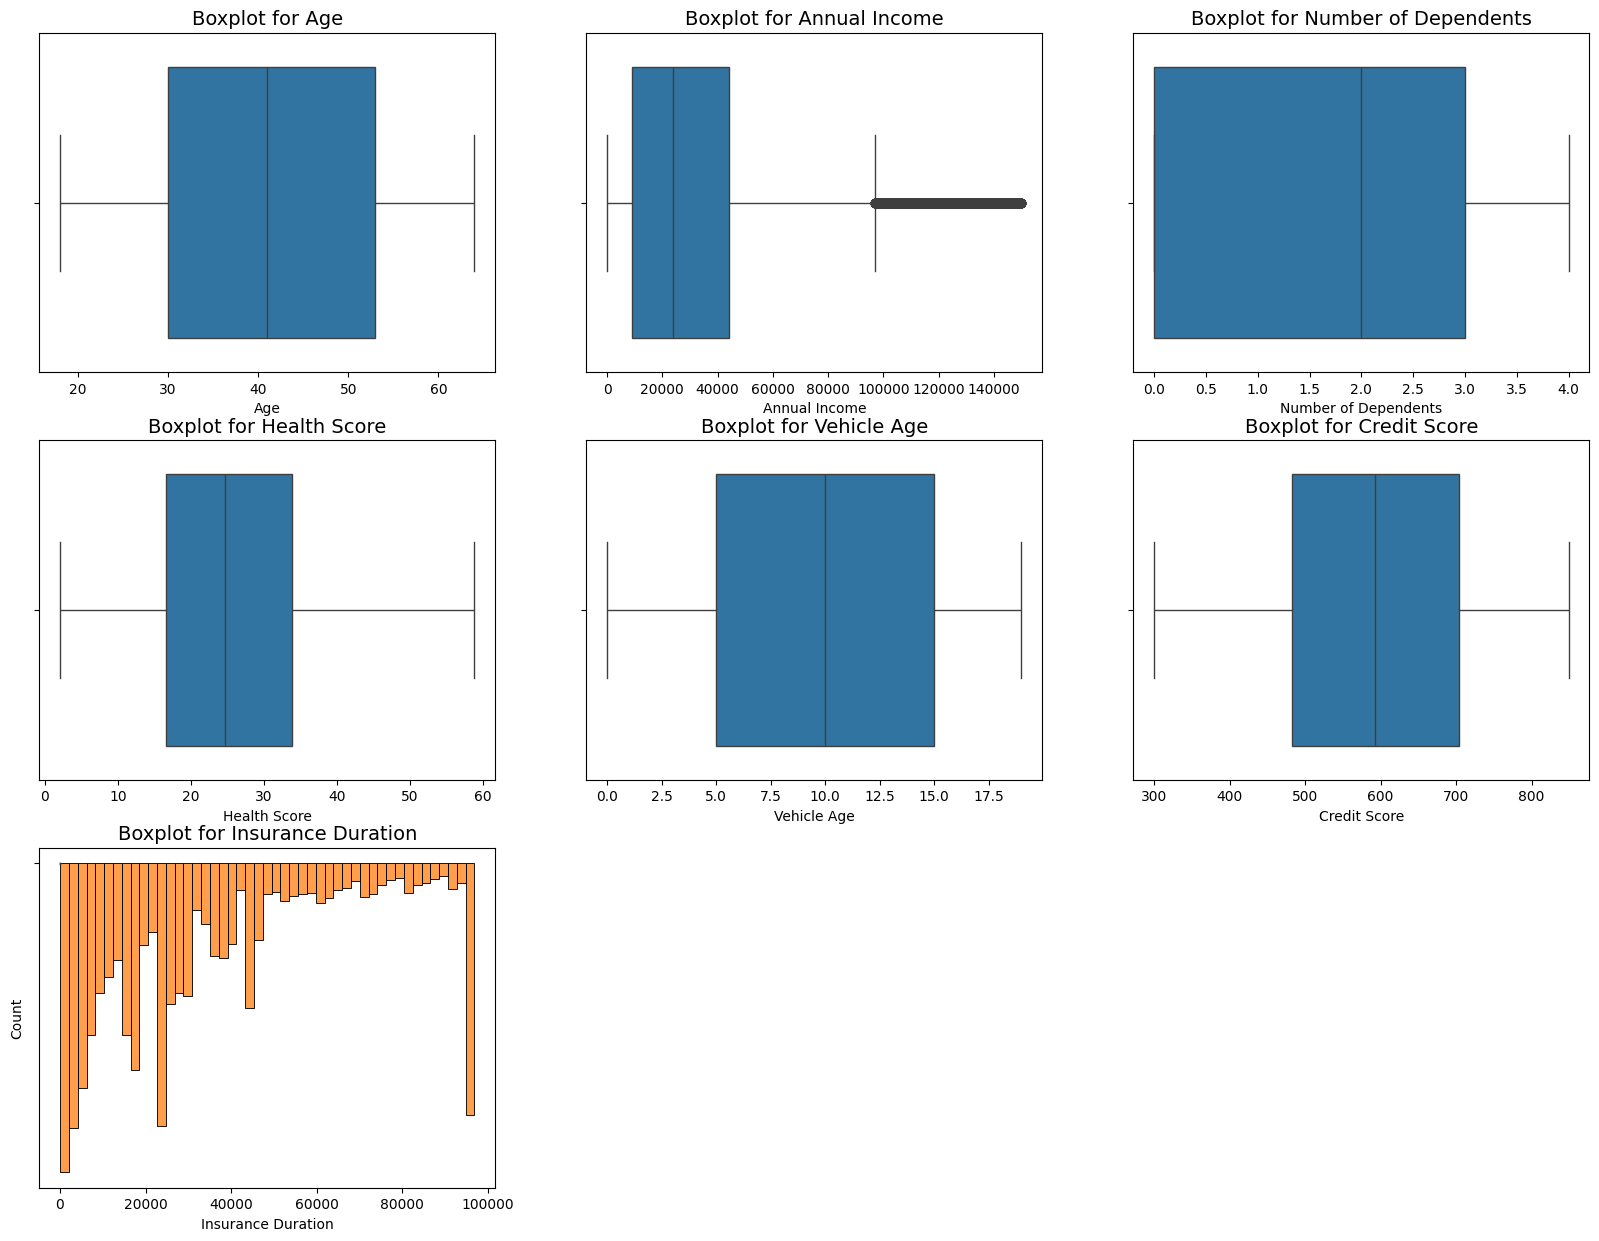

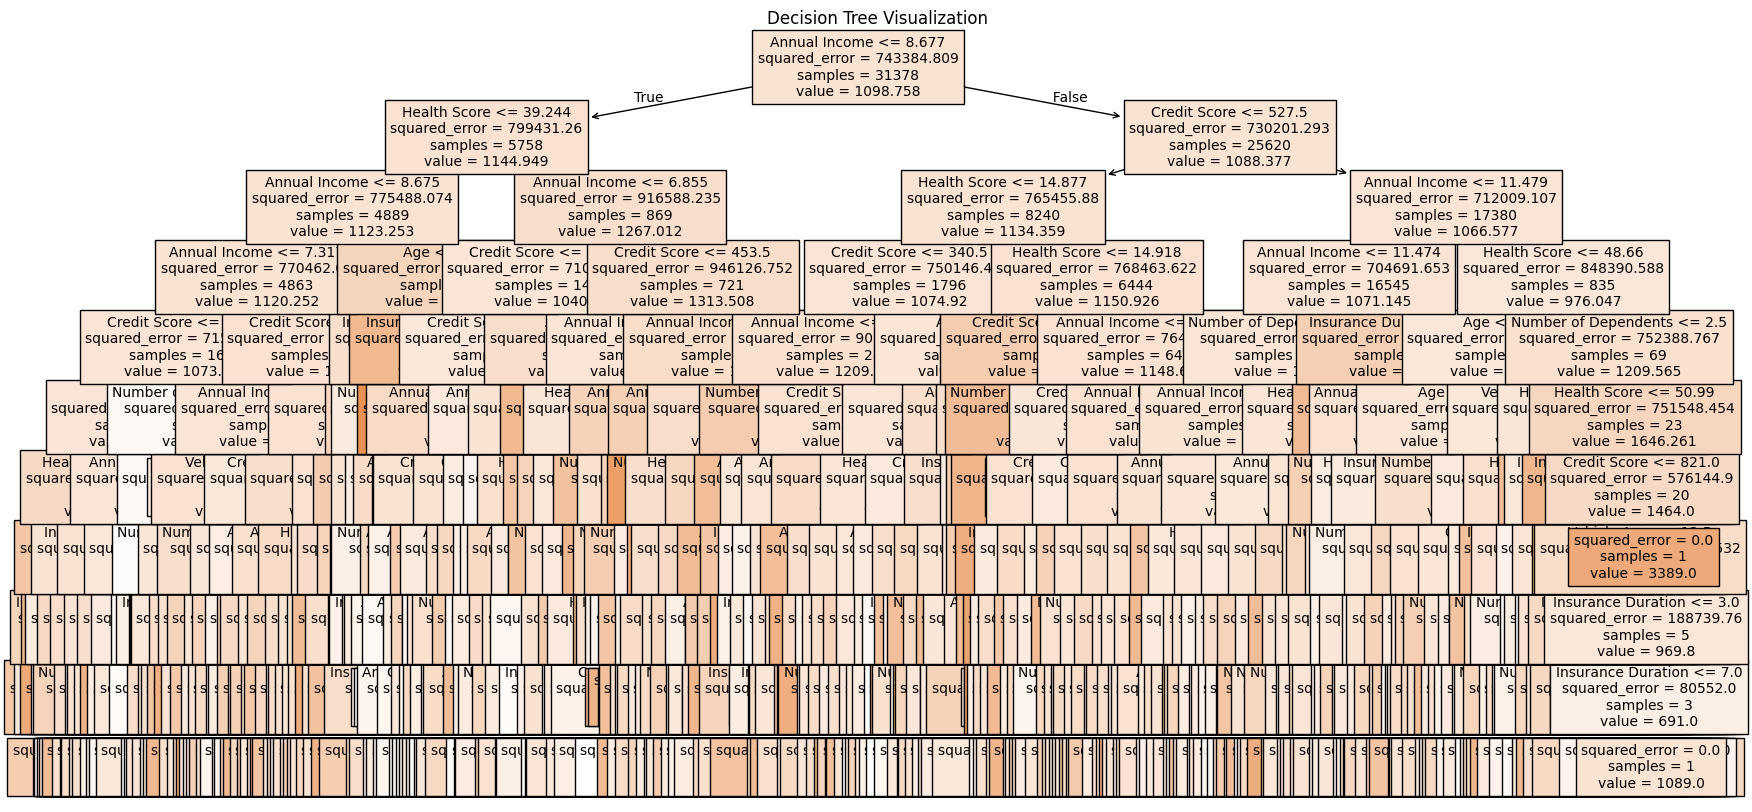

In [3]:
#regression with an insurance dataset .........DECISION TREE............

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/train.csv')
columns_name = df.columns
features_X = df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type","Premium Amount"])
pred = df[["Premium Amount"]]
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)

# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())
# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])

# Drop the rows where that column has very few missing value
features_X = features_X.dropna(subset=["Vehicle Age","Insurance Duration"])
# Split features_X to categorial_columns and numerial_columns
categorial_columns = features_X.select_dtypes(include=["object","category"])
numerical_columns = features_X.select_dtypes(include=["number"])

# Visualize categorial columns data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 20))  # Set the overall figure size
for i, col in enumerate(categorial_columns):
    plt.subplot(1, len(categorial_columns.columns), i + 1)  # Dynamically handle subplot positions

    x = categorial_columns[col].value_counts()
    plt.pie(
        x.values,
        labels=x.index,
        autopct="%1.1f%%",
        textprops={'fontsize': 14}  # Adjust font size for readability
    )
    plt.title(col, fontsize=18)  # Add a title for each subplot

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()

# Visualize numerical data

num_cols = len(numerical_columns.columns)
rows = (num_cols + 2) // 3
plt.figure(figsize=(20, rows * 5))

# Plot boxplots for initial data
for i, col in enumerate(numerical_columns.columns, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(x=numerical_columns[col])
    plt.xlabel(col)
    plt.title(f'Boxplot for {col}', fontsize=14)

# Replace Outliers with mean value
while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns["Annual Income"]=np.clip(numerical_columns["Annual Income"], LowerBound, UpperBound)

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

print(sns.histplot(numerical_columns["Annual Income"]))

from scipy import stats

# Apply Box-Cox transformation first
#numerical_columns["Annual Income"], fitted_lambda = stats.boxcox(numerical_columns["Annual Income"] + 1)
numerical_columns["Annual Income"] = np.log1p(numerical_columns["Annual Income"])

from sklearn.model_selection import train_test_split

# Make both columns consistent with the index across both columns
numerical_columns = numerical_columns.reset_index(drop=True)
X = numerical_columns

# Divide data into training and validation data
pred = pred.loc[X.index]
X = X.reset_index(drop=True)
pred = pred.reset_index(drop=True)

X_train,X_val,y_train,y_val = train_test_split(X,pred,test_size=0.2)

X_train

# Model Development
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Lasso

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)
y_pred = lrmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'The Mean Absolute Error for Linear Regression is {mae}')

lasmodel = Lasso()
lasmodel.fit(X_train,y_train)
y_pred = lasmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"The Mean Absolute Error for Lasso is {mae}")

test_df = pd.read_csv("/content/test.csv")
features_X = test_df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type"])
# Remove columns that have excessive NaN values
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)

# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())

# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])

# Drop the rows where that column has very few missing value
features_X["Vehicle Age"] = features_X["Vehicle Age"].fillna(features_X["Vehicle Age"].median())
features_X["Insurance Duration"] = features_X["Insurance Duration"].fillna(features_X["Insurance Duration"].median())

# Split features_X to categorial_columns and numerial_columns
numerical_columns = features_X.select_dtypes(include=["number"])

while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns.loc[numerical_columns["Annual Income"] >= UpperBound, "Annual Income"] = UpperBound
    numerical_columns.loc[numerical_columns["Annual Income"] <= LowerBound, "Annual Income"] = LowerBound

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

# Apply Box-Cox transformation first
numerical_columns["Annual Income"], fitted_lambda = stats.boxcox(numerical_columns["Annual Income"] + 1)

numerical_columns = numerical_columns.reset_index(drop=True)

X = numerical_columns

test_pred = lrmodel.predict(X).flatten()
submission = pd.DataFrame({
    "id": test_df["id"],
    "Premium Amount": test_pred
})
submission.to_csv("submission.csv",index=False)

print(X.shape)

print("Dimensions of preprocessed training dataset:", features_X.shape)

print("Training data dimensions (X_train):", X_train.shape)
print("Validation data dimensions (X_val):", X_val.shape)
print("Training target dimensions (y_train):", y_train.shape)
print("Validation target dimensions (y_val):", y_val.shape)

#decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train the Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)

# Predict on validation data
y_pred_dt = dt_model.predict(X_val)

# Evaluate Decision Tree model performance
mae_dt = mean_absolute_error(y_val, y_pred_dt)
rmse_dt = mean_squared_error(y_val, y_pred_dt)

print(f"The Mean Absolute Error for Decision Tree is {mae_dt}")
print(f"The Root Mean Squared Error (RMSE) for Decision Tree is {rmse_dt}")

# Predict on test data
test_pred_dt = dt_model.predict(X).flatten()

# Save Decision Tree predictions to submission file
submission_dt = pd.DataFrame({
    "id": test_df["id"],
    "Premium Amount": test_pred_dt
})
submission_dt.to_csv("submission_dt.csv", index=False)

# Visualize the Decision Tree (optional, for understanding the model)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()


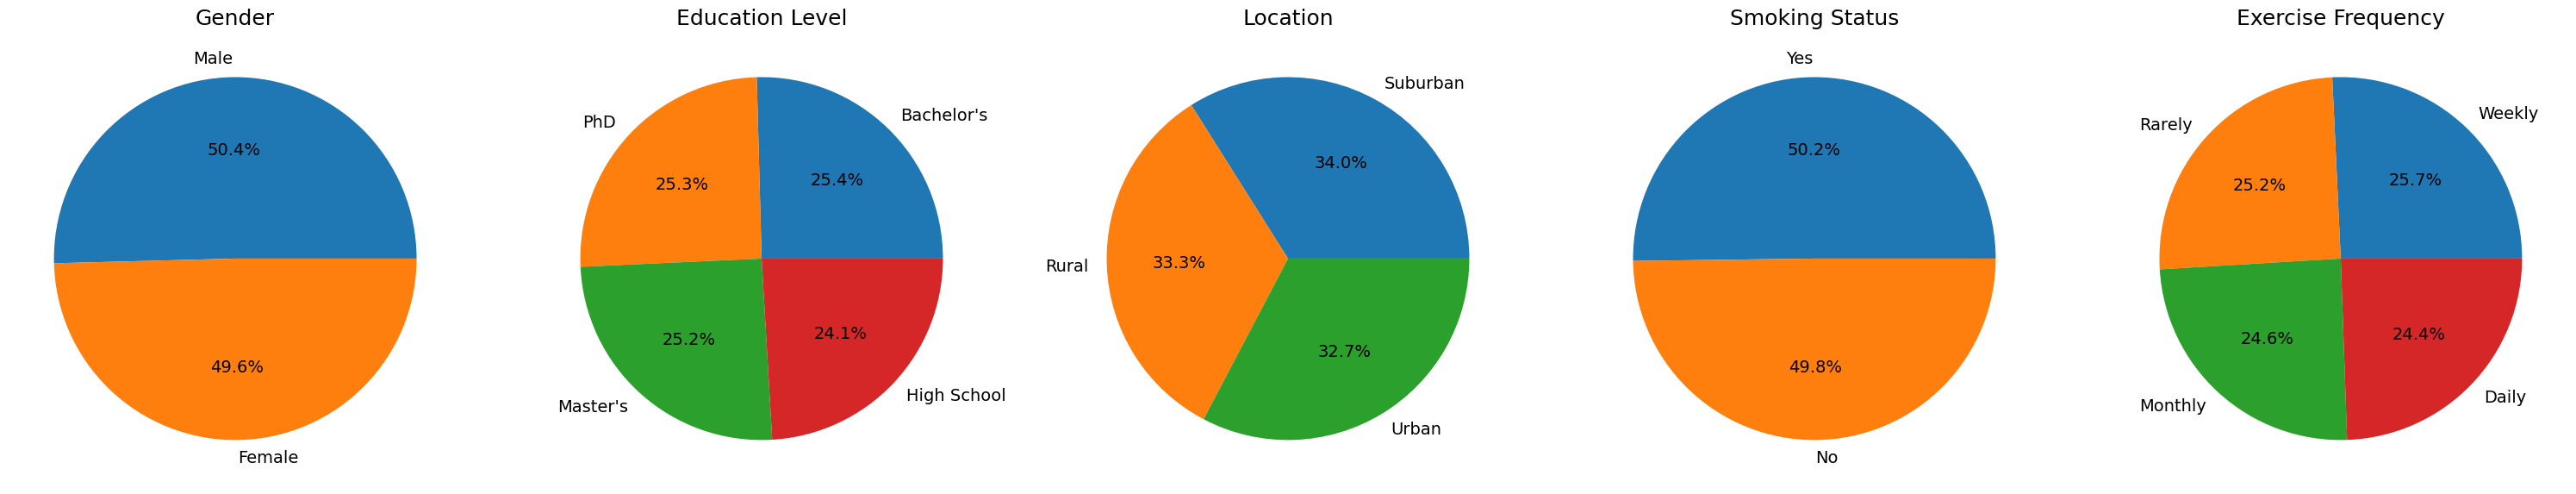

Axes(0.125,0.11;0.227941x0.226471)
The Mean Absolute Error for Linear Regression is 667.5852833655198
The Mean Absolute Error for Lasso is 667.5934407185086
(46965, 7)
Dimensions of preprocessed training dataset: (46965, 12)
Training data dimensions (X_train): (47035, 7)
Validation data dimensions (X_val): (11759, 7)
Training target dimensions (y_train): (47035, 1)
Validation target dimensions (y_val): (11759, 1)
The Mean Absolute Error for SVR is 638.181128463873
The Root Mean Squared Error (RMSE) for SVR is 793762.9778494295


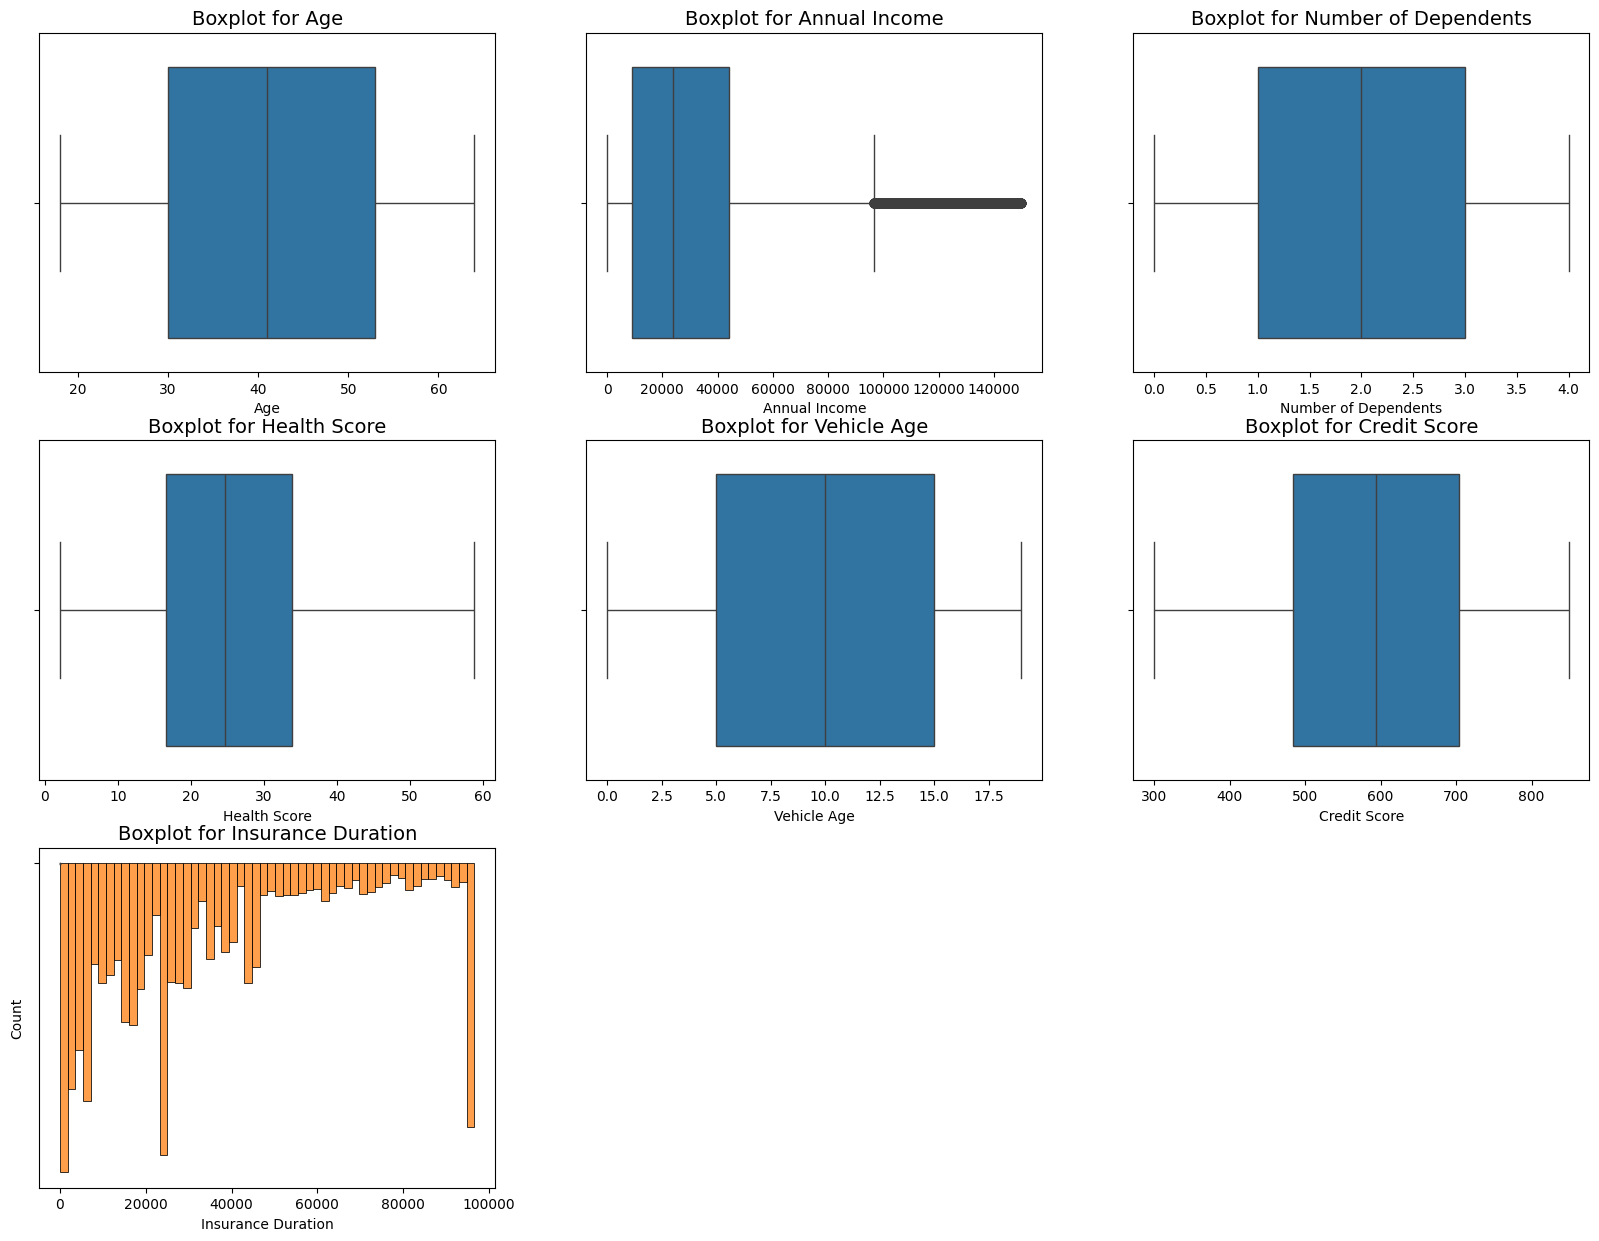

In [4]:
#regression with an insurance dataset SVR regression..........

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/content/train.csv')
columns_name = df.columns
features_X = df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type","Premium Amount"])
pred = df[["Premium Amount"]]
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)

# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())
# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])

# Drop the rows where that column has very few missing value
features_X = features_X.dropna(subset=["Vehicle Age","Insurance Duration"])
# Split features_X to categorial_columns and numerial_columns
categorial_columns = features_X.select_dtypes(include=["object","category"])
numerical_columns = features_X.select_dtypes(include=["number"])

# Visualize categorial columns data
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30, 20))  # Set the overall figure size
for i, col in enumerate(categorial_columns):
    plt.subplot(1, len(categorial_columns.columns), i + 1)  # Dynamically handle subplot positions

    x = categorial_columns[col].value_counts()
    plt.pie(
        x.values,
        labels=x.index,
        autopct="%1.1f%%",
        textprops={'fontsize': 14}  # Adjust font size for readability
    )
    plt.title(col, fontsize=18)  # Add a title for each subplot

plt.tight_layout()  # Ensure subplots don't overlap
plt.show()

# Visualize numerical data

num_cols = len(numerical_columns.columns)
rows = (num_cols + 2) // 3
plt.figure(figsize=(20, rows * 5))

# Plot boxplots for initial data
for i, col in enumerate(numerical_columns.columns, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(x=numerical_columns[col])
    plt.xlabel(col)
    plt.title(f'Boxplot for {col}', fontsize=14)

# Replace Outliers with mean value
while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns["Annual Income"]=np.clip(numerical_columns["Annual Income"], LowerBound, UpperBound)

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

print(sns.histplot(numerical_columns["Annual Income"]))

from scipy import stats

# Apply Box-Cox transformation first
#numerical_columns["Annual Income"], fitted_lambda = stats.boxcox(numerical_columns["Annual Income"] + 1)
numerical_columns["Annual Income"] = np.log1p(numerical_columns["Annual Income"])

from sklearn.model_selection import train_test_split

# Make both columns consistent with the index across both columns
numerical_columns = numerical_columns.reset_index(drop=True)
X = numerical_columns

# Divide data into training and validation data
pred = pred.loc[X.index]
X = X.reset_index(drop=True)
pred = pred.reset_index(drop=True)

X_train,X_val,y_train,y_val = train_test_split(X,pred,test_size=0.2)

X_train

# Model Development
# Import necessary libraries
from sklearn.linear_model import LinearRegression, Lasso

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)
y_pred = lrmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'The Mean Absolute Error for Linear Regression is {mae}')

lasmodel = Lasso()
lasmodel.fit(X_train,y_train)
y_pred = lasmodel.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f"The Mean Absolute Error for Lasso is {mae}")

test_df = pd.read_csv("/content/test.csv")
features_X = test_df.drop(columns=["id","Marital Status","Policy Start Date","Customer Feedback","Property Type","Policy Type"])
# Remove columns that have excessive NaN values
features_X=features_X.drop(["Occupation","Previous Claims"],axis=1)

# Impute Age, Credit Score, Health Score and Annual Income with the median
features_X["Age"] = features_X["Age"].fillna(features_X["Age"].median())
features_X["Annual Income"] = features_X["Annual Income"].fillna(features_X["Annual Income"].median())
features_X["Health Score"] = features_X["Health Score"].fillna(features_X["Health Score"].median())
features_X["Credit Score"] = features_X["Credit Score"].fillna(features_X["Credit Score"].median())

# Impute Number of Dependents with mode
features_X["Number of Dependents"] = features_X["Number of Dependents"].fillna(features_X["Number of Dependents"].mode()[0])

# Drop the rows where that column has very few missing value
features_X["Vehicle Age"] = features_X["Vehicle Age"].fillna(features_X["Vehicle Age"].median())
features_X["Insurance Duration"] = features_X["Insurance Duration"].fillna(features_X["Insurance Duration"].median())

# Split features_X to categorial_columns and numerial_columns
numerical_columns = features_X.select_dtypes(include=["number"])

while True:
    Q1 = numerical_columns["Annual Income"].quantile(0.25)
    Q3 = numerical_columns["Annual Income"].quantile(0.75)
    IQR = Q3 - Q1
    LowerBound = Q1 - 1.5 * IQR
    UpperBound = Q3 + 1.5 * IQR

    # Check for outliers and replace
    numerical_columns.loc[numerical_columns["Annual Income"] >= UpperBound, "Annual Income"] = UpperBound
    numerical_columns.loc[numerical_columns["Annual Income"] <= LowerBound, "Annual Income"] = LowerBound

    outliers = ((numerical_columns["Annual Income"] > UpperBound) | (numerical_columns["Annual Income"] < LowerBound))
    if not outliers.any():
        break

# Apply Box-Cox transformation first
numerical_columns["Annual Income"], fitted_lambda = stats.boxcox(numerical_columns["Annual Income"] + 1)

numerical_columns = numerical_columns.reset_index(drop=True)

X = numerical_columns

test_pred = lrmodel.predict(X).flatten()
submission = pd.DataFrame({
    "id": test_df["id"],
    "Premium Amount": test_pred
})
submission.to_csv("submission.csv",index=False)

print(X.shape)

print("Dimensions of preprocessed training dataset:", features_X.shape)

print("Training data dimensions (X_train):", X_train.shape)
print("Validation data dimensions (X_val):", X_val.shape)
print("Training target dimensions (y_train):", y_train.shape)
print("Validation target dimensions (y_val):", y_val.shape)

from sklearn.svm import SVR

# Create and train SVR model with RBF kernel
svr_model = SVR(kernel='rbf', C=0.1, epsilon=0.5)
svr_model.fit(X_train, y_train.values.ravel())  # Flatten y_train to a 1D array
# Predict on validation data
y_pred_svr = svr_model.predict(X_val)
# Evaluate SVR model
mae_svr = mean_absolute_error(y_val, y_pred_svr)
rmse_svr = mean_squared_error(y_val, y_pred_svr)
print(f"The Mean Absolute Error for SVR is {mae_svr}")
print(f"The Root Mean Squared Error (RMSE) for SVR is {rmse_svr}")
# Predict on test data
test_pred_svr = svr_model.predict(X).flatten()
# Save SVR predictions to submission file
submission_svr = pd.DataFrame({
  "id": test_df["id"],
  "Premium Amount": test_pred_svr
})
submission_svr.to_csv("submission_svr.csv", index=False)
